<p style="background-color: rgb(247, 230, 202); font-size: 300%; text-align: center; border-radius: 40px 40px; color: rgb(162, 87, 79); font-weight: bold; font-family: 'Roboto'; border: 4px solid rgb(162, 87, 79);">Introduction</p>

<div style="background-color: rgb(247, 230, 202); border: 4px solid rgb(162, 87, 79); border-radius: 40px; padding: 20px; font-family: 'Roboto'; color: rgb(162, 87, 79); text-align: left; font-size: 120%;">
    <ul style="list-style-type: square; padding-left: 20px;">
        <li style="margin-top: 10px;">HLA columns are recalculated as per <a href="https://www.kaggle.com/code/albansteff/cibmtr-eda-ensemble-model-recalculate-hla" style="color: #A2574F; text-decoration: underline;">this</a> notebook.</li>
        <li style="margin-top: 10px;">Missing values are replaced with:
            <ul style="list-style-type: circle; margin-top: 10px; margin-bottom: 10px;">
                <li>-1 for numeric columns</li>
                <li>Unknown for categorical columns</li>
            </ul>
        </li>
        <li style="margin-top: 10px;">
            LightGBM and CatBoost are trained on 3 different targets, estimated from the survival models:
            <ul style="list-style-type: circle; margin-top: 10px; margin-bottom: 10px;">
                <li>Cox</li>
                <li>Kaplan-Meier</li>
                <li>Nelson-Aalen</li>
            </ul>
        </li>
        <li style="margin-top: 10px;">Two additional CatBoost model are trained, with Cox loss function.</li>
        <li style="margin-top: 10px;">As per <a href="https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/553061" style="color: #A2574F; text-decoration: underline;">this</a> discussion post, the target is consisted of the Out-of-Fold predictions of the survival models on the validation folds to prevent target leakage.</li>
        <li style="margin-top: 10px;">
            The ensemble prediction for each sample is computed as:
            <ul style="list-style-type: circle; margin-top: 10px; margin-bottom: 10px;">
                <p style="margin-top: 10px; font-size: 110%; color: #A2574F; font-family: 'Roboto'; text-align: left;">
                    $ \text{preds}_{\text{ensemble}} = \sum_{i=1}^{n} w_i \cdot \text{rankdata}(\text{preds}_i) $
                </p>
                where $n$ is the number of models, $w_i$ is the weight assigned to the $i$-th model, and $\text{rankdata}(\text{preds}_i)$ is the rank of predictions from the $i$-th model.
            </ul>
        </li>
        <li style="margin-top: 10px;">Last but not least, since the competition metric evaluates only the order of predictions and not their magnitude, the model weights are not required to sum to 1, nor should the predictions fall within a predefined range.</li>
    </ul>
</div>

<p style="background-color: rgb(247, 230, 202); font-size: 300%; text-align: center; border-radius: 40px 40px; color: rgb(162, 87, 79); font-weight: bold; font-family: 'Roboto'; border: 4px solid rgb(162, 87, 79);">Install Libraries</p>

In [ ]:
# !pip install polars

In [4]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
autograd is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=c95acfe50ce4965df90cbc546f7223da15403a4f6bb95f7a4d39e3acea5a5b8f
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


In [294]:
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')
import numpy as np
import polars as pl
import pandas as pd
import plotly.colors as pc
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'
pd.options.display.max_columns = None


from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter



import lightgbm as lgb
from metric import score
from scipy.stats import rankdata 
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold


from sklearn.base import BaseEstimator, RegressorMixin
import contextlib, io
import ydf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    LabelEncoder,
    label_binarize,
    OrdinalEncoder,
)
from category_encoders import CatBoostEncoder, MEstimateEncoder

from sklearn.ensemble import (
    # RandomForestClassifier,
    # VotingClassifier,
    # HistGradientBoostingClassifier,
    # GradientBoostingClassifier,
    HistGradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.linear_model import (
    RidgeClassifier,
    LogisticRegression,
    LinearRegression,
    Ridge,
    BayesianRidge,
)

from sklearn import set_config
import os

import optuna
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    mean_squared_error,
    precision_recall_curve,
    make_scorer,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    matthews_corrcoef,
    mean_absolute_percentage_error,
)
from scipy.stats import norm, skew

from colorama import Fore, Style, init
from copy import deepcopy
from sklearn.base import BaseEstimator, TransformerMixin
from pprint import pprint
from sklearn.model_selection import (
    train_test_split,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    KFold,
    RepeatedKFold,
    cross_val_score,
    StratifiedGroupKFold,
    GroupKFold,
)
from xgboost import DMatrix, XGBClassifier, XGBRegressor
from lightgbm import (
    log_evaluation,
    early_stopping,
    LGBMClassifier,
    LGBMRegressor,
    Dataset,
)
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from tqdm.notebook import tqdm
from optuna.samplers import TPESampler, CmaEsSampler
from optuna.pruners import HyperbandPruner
from functools import partial
from IPython.display import display_html, clear_output
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
import gc
import re
import holidays
import requests

import warnings

warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")
import warnings
import os
import plotly.graph_objects as go

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

ydf.verbose(2)
from ydf import GradientBoostedTreesLearner
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Define log directory with timestamp
log_dir = "./logs/fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [295]:
class CFG:

    train_path = Path('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
    test_path = Path('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
    subm_path = Path('/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv')
    
    colorscale = 'Redor'
    color = '#A2574F'

    batch_size = 32768
    early_stop = 300
    penalizer = 0.01
    n_splits = 5

    weights = [2, 1, 6, 3, 6, 3, 6, 6]

    ctb_params = {
        'loss_function': 'RMSE',
        'learning_rate': 0.03,
        'random_state': 52942,
        'task_type': 'CPU',
        'num_trees': 6000,
        'reg_lambda': 8.0,
        'depth': 8
    }

    lgb_params = {
        'objective': 'regression',
        'min_child_samples': 32,
        'num_iterations': 6000,
        'learning_rate': 0.03,
        'extra_trees': True,
        'reg_lambda': 8.0,
        'reg_alpha': 0.1,
        'num_leaves': 64,
        'metric': 'rmse',
        'max_depth': 8,
        'device': 'cpu',
        'max_bin': 128,
        'verbose': -1,
        'seed': 42
    }

    cox1_params = {
        'grow_policy': 'Depthwise',
        'min_child_samples': 8,
        'loss_function': 'Cox',
        'learning_rate': 0.03,
        'random_state': 42,
        'task_type': 'CPU',
        'num_trees': 6000,
        'reg_lambda': 8.0,
        'depth': 8
    }

    cox2_params = {
        'grow_policy': 'Lossguide',
        'min_child_samples': 2,
        'loss_function': 'Cox',
        'learning_rate': 0.03,
        'random_state': 42,
        'task_type': 'CPU',
        'num_trees': 6000,
        'reg_lambda': 8.0,
        'num_leaves': 32,
        'depth': 8
    }

In [67]:
class FE:
    def __init__(self, batch_size):
        self._batch_size = batch_size
    def _load_data(self, path):
        return pl.read_csv(path, batch_size=self._batch_size)
    def _update_hla_columns(self, df):
        df = df.with_columns(
            pl.col('hla_match_a_low').fill_null(0)
            .add(pl.col('hla_match_b_low').fill_null(0))
            
            .add(pl.col('hla_match_drb1_high').fill_null(0))
            .alias('hla_nmdp_6'),
            
            pl.col('hla_match_a_low').fill_null(0)
            .add(pl.col('hla_match_b_low').fill_null(0))
            .add(pl.col('hla_match_drb1_low').fill_null(0))
            .alias('hla_low_res_6'),
            
            pl.col('hla_match_a_high').fill_null(0)
            .add(pl.col('hla_match_b_high').fill_null(0))
            .add(pl.col('hla_match_drb1_high').fill_null(0))
            .alias('hla_high_res_6'),
            
            pl.col('hla_match_a_low').fill_null(0)
            .add(pl.col('hla_match_b_low').fill_null(0))
            .add(pl.col('hla_match_c_low').fill_null(0))
            .add(pl.col('hla_match_drb1_low').fill_null(0))
            .alias('hla_low_res_8'),
            
            pl.col('hla_match_a_high').fill_null(0)
            .add(pl.col('hla_match_b_high').fill_null(0))
            .add(pl.col('hla_match_c_high').fill_null(0))
            .add(pl.col('hla_match_drb1_high').fill_null(0))
            .alias('hla_high_res_8'),
            
            pl.col('hla_match_a_low').fill_null(0)
            .add(pl.col('hla_match_b_low').fill_null(0))
            .add(pl.col('hla_match_c_low').fill_null(0))
            .add(pl.col('hla_match_drb1_low').fill_null(0))
            .add(pl.col('hla_match_dqb1_low').fill_null(0))
            .alias('hla_low_res_10'),
            
            pl.col('hla_match_a_high').fill_null(0)
            .add(pl.col('hla_match_b_high').fill_null(0))
            .add(pl.col('hla_match_c_high').fill_null(0))
            .add(pl.col('hla_match_drb1_high').fill_null(0))
            .add(pl.col('hla_match_dqb1_high').fill_null(0))
            .alias('hla_high_res_10'),
            
        )
    
        return df

    def _cast_datatypes(self, df):

        num_cols = [
            'hla_high_res_8',
            'hla_low_res_8',
            'hla_high_res_6',
            'hla_low_res_6',
            'hla_high_res_10',
            'hla_low_res_10',
            'hla_match_dqb1_high',
            'hla_match_dqb1_low',
            'hla_match_drb1_high',
            'hla_match_drb1_low',
            'hla_nmdp_6',
            'year_hct',
            'hla_match_a_high',
            'hla_match_a_low',
            'hla_match_b_high',
            'hla_match_b_low',
            'hla_match_c_high',
            'hla_match_c_low',
            'donor_age',
            'age_at_hct',
            'comorbidity_score',
            'karnofsky_score',
            'efs',
            'efs_time'
        ]

        for col in df.columns:
            if col in num_cols:
                df = df.with_columns(pl.col(col).fill_null(-1).cast(pl.Float32))  
            else:
                df = df.with_columns(pl.col(col).fill_null('Unknown').cast(pl.String))  
        return df.with_columns(pl.col('ID').cast(pl.Int32))

    def info(self, df):
        print(f'\nShape of dataframe: {df.shape}') 
        mem = df.memory_usage().sum() / 1024**2
        print('Memory usage: {:.2f} MB\n'.format(mem))
        display(df.head())

    def apply_fe(self, path):
        df = self._load_data(path)   
        df = self._update_hla_columns(df)                     
        df = self._cast_datatypes(df)        
        df = df.to_pandas()
        self.info(df)
        cat_cols = [col for col in df.columns if df[col].dtype == pl.String]
        return df, cat_cols
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], event_observed=df[event_col])
    survival_probabilities = kmf.survival_function_at_times(df[time_col]).values.flatten()
    return survival_probabilities
def more_fe(train):
    train["y"] = train.efs_time.values
    mx = train.loc[train.efs==1,"efs_time"].max()
    mn = train.loc[train.efs==0,"efs_time"].min()
    train.loc[train.efs==0,"y"] = train.loc[train.efs==0,"y"] + mx - mn
    train.y = train.y.rank()
    train.loc[train.efs==0,"y"] += len(train)//2
    train.y = train.y / train.y.max()
    # ""
    
    for race in sorted(train_data['race_group'].unique()):
        train.loc[train['race_group']==race,"target"] = transform_survival_probability(train[train['race_group']==race], time_col='efs_time', event_col='efs')
        gap=(train.loc[(train['race_group']==race)&(train['efs']==0)]['target'].max()-train.loc[(train['race_group']==race)&(train['efs']==1)]['target'].min())/2
        train.loc[(train['race_group']==race)&(train['efs']==0),'target']-=gap
    return train


def pcaaug_arr(x, y):
    n_components = int(np.min(x.shape)*0.75)
    pca = sklearn.decomposition.PCA(n_components=n_components)
    data = np.concatenate([x, y.reshape([-1, 1])], axis=1)
    pca_res = pca.fit_transform(data)
    x_aug = pca.inverse_transform(pca_res)
    x_aug = x_aug[:, :-1]
    return x_aug, y
class Targets:

    def __init__(self, data, cat_cols, penalizer, n_splits):
        
        self.data = data
        self.cat_cols = cat_cols
        
        self._length = len(self.data)
        self._penalizer = penalizer
        self._n_splits = n_splits

    def _prepare_cv(self):
        
        oof_preds = np.zeros(self._length)
            
        cv = KFold(n_splits=self._n_splits, shuffle=True, random_state=42)

        return cv, oof_preds

    def validate_model(self, preds, title):
            
        y_true = self.data[['ID', 'efs', 'efs_time', 'race_group']].copy()
        y_pred = self.data[['ID']].copy()
        
        y_pred['prediction'] = preds
            
        c_index_score = score(y_true.copy(), y_pred.copy(), 'ID')
        print(f'Overall Stratified C-Index Score for {title}: {c_index_score:.4f}')

    def create_target1(self):  

        '''
        Constant columns are dropped if they exist in a fold. Otherwise, the code produces error:

        delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: 
        https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
        '''

        cv, oof_preds = self._prepare_cv()

        # Apply one hot encoding to categorical columns
        data = pd.get_dummies(self.data, columns=self.cat_cols, drop_first=True).drop('ID', axis=1) 

        for train_index, valid_index in cv.split(data):

            train_data = data.iloc[train_index]
            valid_data = data.iloc[valid_index]

            # Drop constant columns if they exist
            train_data = train_data.loc[:, train_data.nunique() > 1]
            valid_data = valid_data[train_data.columns]

            cph = CoxPHFitter(penalizer=self._penalizer)
            cph.fit(train_data, duration_col='efs_time', event_col='efs')
            
            oof_preds[valid_index] = cph.predict_partial_hazard(valid_data)              

        self.data['target1'] = oof_preds 
        self.validate_model(oof_preds, 'Cox') 

        return self.data

    def create_target2(self):        

        cv, oof_preds = self._prepare_cv()

        for train_index, valid_index in cv.split(self.data):

            train_data = self.data.iloc[train_index]
            valid_data = self.data.iloc[valid_index]

            kmf = KaplanMeierFitter()
            kmf.fit(durations=train_data['efs_time'], event_observed=train_data['efs'])
            
            oof_preds[valid_index] = kmf.survival_function_at_times(valid_data['efs_time']).values

        self.data['target2'] = oof_preds  
        self.validate_model(oof_preds, 'Kaplan-Meier')

        return self.data

    def create_target3(self):        

        cv, oof_preds = self._prepare_cv()

        for train_index, valid_index in cv.split(self.data):

            train_data = self.data.iloc[train_index]
            valid_data = self.data.iloc[valid_index]
            
            naf = NelsonAalenFitter()
            naf.fit(durations=train_data['efs_time'], event_observed=train_data['efs'])
            
            oof_preds[valid_index] = -naf.cumulative_hazard_at_times(valid_data['efs_time']).values

        self.data['target3'] = oof_preds  
        self.validate_model(oof_preds, 'Nelson-Aalen')

        return self.data

    def create_target4(self):

        self.data['target4'] = self.data.efs_time.copy()
        self.data.loc[self.data.efs == 0, 'target4'] *= -1

        return self.data


def FE_yun(df):
    print("< deal with outlier >")
    df['nan_value_each_row'] = df.isnull().sum(axis=1)
    #year_hct=2020 only 4 rows.
    df['year_hct']=df['year_hct'].replace(2020,2019)
    df['age_group']=df['age_at_hct']//10
    #karnofsky_score 40 only 10 rows.
    df['karnofsky_score']=df['karnofsky_score'].replace(40,50)
    #hla_high_res_8=2 only 2 rows.
    df['hla_high_res_8']=df['hla_high_res_8'].replace(2,3)
    #hla_high_res_6=0 only 1 row.
    df['hla_high_res_6']=df['hla_high_res_6'].replace(0,2)
    #hla_high_res_10=3 only 1 row.
    df['hla_high_res_10']=df['hla_high_res_10'].replace(3,4)
    #hla_low_res_8=2 only 1 row.
    df['hla_low_res_8']=df['hla_low_res_8'].replace(2,3)
    df['dri_score']=df['dri_score'].replace('Missing disease status','N/A - disease not classifiable')
    df['dri_score_NA']=df['dri_score'].apply(lambda x:int('N/A' in str(x)))
    for col in ['diabetes','pulm_moderate','cardiac']:
        df.loc[df[col].isna(),col]='Not done'

    print("< cross feature >")
    df['donor_age-age_at_hct']=df['donor_age']-df['age_at_hct']
    df['comorbidity_score+karnofsky_score']=df['comorbidity_score']+df['karnofsky_score']
    df['comorbidity_score-karnofsky_score']=df['comorbidity_score']-df['karnofsky_score']
    df['comorbidity_score*karnofsky_score']=df['comorbidity_score']*df['karnofsky_score']
    df['comorbidity_score/karnofsky_score']=df['comorbidity_score']/df['karnofsky_score']
    
    print("< fillna >")
    print(df[nunique50].astype(str).fillna('NaN').shape, df[nunique50].shape)
        
    # If you want to ensure that the columns are treated as strings and NaNs are replaced:
    for col in nunique50:
        train_data[col] = train_data[col].astype(str).replace('nan', 'NaN')
    print("< combine category feature >")
    for i in range(len(nunique2)):
        for j in range(i+1,len(nunique2)):
            df[nunique2[i]+nunique2[j]]=df[nunique2[i]].astype(str)+df[nunique2[j]].astype(str)
    
    # print("< drop useless columns >")
    # df.drop(['ID'],axis=1,inplace=True,errors='ignore')
    return df

def reduce_mem(df):

    numerics = [
        "int16",
        "int32",
        "int64",
        "float16",
        "float32",
        "float64",
        "uint16",
        "uint32",
        "uint64",
    ]

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if "int" in str(col_type):
                if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif (
                    c_min >= np.iinfo(np.int16).min
                    and c_max < np.iinfo(np.int16).max
                ):
                    df[col] = df[col].astype(np.int16)
                elif (
                    c_min >= np.iinfo(np.int32).min
                    and c_max < np.iinfo(np.int32).max
                ):
                    df[col] = df[col].astype(np.int32)
                elif (
                    c_min >= np.iinfo(np.int64).min
                    and c_max < np.iinfo(np.int64).max
                ):
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min >= np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                if (
                    c_min >= np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    return df

In [71]:
fe = FE(CFG.batch_size)
train_data, cat_cols = fe.apply_fe(CFG.train_path)
train_solution=train_data[['ID','efs','efs_time','race_group']].copy()
test_data, _ = fe.apply_fe(CFG.test_path)

#nunique=2
nunique2=[col for col in train_data.columns if train_data[col].nunique()==2 and col!='efs']
#nunique<50
nunique50=[col for col in train_data.columns if train_data[col].nunique()<50 and col!='efs']+['age_group','dri_score_NA']

combine_category_cols=[]
for i in range(len(nunique2)):
    for j in range(i+1,len(nunique2)):
        combine_category_cols.append(nunique2[i]+nunique2[j])  

total_category_feature=nunique50+combine_category_cols

target_stat=[]
for j in range(len(total_category_feature)):
   for col in ['donor_age','age_at_hct','target']:
    target_stat.append( (total_category_feature[j],col,['count','mean','max','std','skew']) )

train_data = more_fe(train_data)
train_data = FE_yun(train_data)
test_data = FE_yun(test_data)
cat_cols += ['graft_typeprod_type']


Shape of dataframe: (28800, 60)
Memory usage: 10.44 MB



,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,Unknown,No,-1.0,6.0,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,8.0,2.0,Unknown,6.0,2.0,No,2.0,2.0,BM,Unknown,Unknown,Not Hispanic or Latino,2016.0,No,Unknown,Yes,Unknown,2.0,No,-1.000000,No,2.0,No,9.942000,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,Unknown,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.355999
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008.0,No,Positive,No,Permissive,2.0,No,72.290001,No,2.0,No,43.705002,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672000
2,2,N/A - non-malignant indication,No,Unknown,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Unknown,Unknown,Not Hispanic or Latino,2019.0,No,Unknown,Yes,Unknown,2.0,No,-1.000000,No,2.0,No,33.997002,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.792999
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009.0,No,Positive,No,Permissive,2.0,No,29.230000,No,2.0,No,43.244999,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.348999
4,4,High,No,Unknown,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,Unknown,6.0,2.0,No,2.0,2.0,PB,Unknown,MAC,Hispanic or Latino,2018.0,No,Unknown,Yes,Unknown,2.0,No,56.810001,No,2.0,No,29.740000,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223000



Shape of dataframe: (3, 58)
Memory usage: 0.00 MB



,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,28800,N/A - non-malignant indication,No,Unknown,No,-1.0,6.0,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,8.0,2.0,Unknown,6.0,2.0,No,2.0,2.0,BM,Unknown,Unknown,Not Hispanic or Latino,2016.0,No,Unknown,Yes,Unknown,2.0,No,-1.000000,No,2.0,No,9.942000,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,Unknown,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0
1,28801,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008.0,No,Positive,No,Permissive,2.0,No,72.290001,No,2.0,No,43.705002,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0
2,28802,N/A - non-malignant indication,No,Unknown,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Unknown,Unknown,Not Hispanic or Latino,2019.0,No,Unknown,Yes,Unknown,2.0,No,-1.000000,No,2.0,No,33.997002,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0


< deal with outlier >
< cross feature >
< fillna >
(28800, 57) (28800, 57)
< combine category feature >
< deal with outlier >
< cross feature >
< fillna >
(3, 57) (3, 57)
< combine category feature >


In [72]:
t = Targets(train_data, cat_cols, CFG.penalizer, 5)
t.create_target1()
t.create_target2()
t.create_target3()


Overall Stratified C-Index Score for Cox: 0.9962
Overall Stratified C-Index Score for Kaplan-Meier: 0.9983
Overall Stratified C-Index Score for Nelson-Aalen: 0.9983


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,y,target,nan_value_each_row,age_group,dri_score_NA,donor_age-age_at_hct,comorbidity_score+karnofsky_score,comorbidity_score-karnofsky_score,comorbidity_score*karnofsky_score,comorbidity_score/karnofsky_score,graft_typeprod_type,target1,target2,target3
0,0,N/A - non-malignant indication,No,Unknown,No,-1.0,6.0,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,8.0,2.0,Unknown,6.0,2.0,No,2.0,2.0,BM,Unknown,Unknown,Not Hispanic or Latino,2016.0,No,Unknown,Yes,Unknown,2.0,No,-1.000000,No,2.0,No,9.942000,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,Unknown,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.355999,0.875370,0.318921,0,0.0,1,-10.942000,90.0,-90.0,0.0,0.000000,Bone marrowBM,0.000230,0.461962,-0.772247
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008.0,No,Positive,No,Permissive,2.0,No,72.290001,No,2.0,No,43.705002,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672000,0.101458,0.849116,0,4.0,0,28.584999,93.0,-87.0,270.0,0.033333,Peripheral bloodPB,39798.867971,0.847723,-0.165197
2,2,N/A - non-malignant indication,No,Unknown,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Unknown,Unknown,Not Hispanic or Latino,2019.0,No,Unknown,Yes,Unknown,2.0,No,-1.000000,No,2.0,No,33.997002,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.792999,0.726134,0.323071,0,3.0,1,-34.997002,90.0,-90.0,0.0,0.000000,Bone marrowBM,0.000870,0.460785,-0.774799
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009.0,No,Positive,No,Permissive,2.0,No,29.230000,No,2.0,No,43.244999,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.348999,0.990463,0.233885,0,4.0,0,-14.014999,90.0,-90.0,0.0,0.000000,Bone marrowBM,0.000043,0.455588,-0.786139
4,4,High,No,Unknown,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,Unknown,6.0,2.0,No,2.0,2.0,PB,Unknown,MAC,Hispanic or Latino,2018.0,No,Unknown,Yes,Unknown,2.0,No,56.810001,No,2.0,No,29.740000,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223000,0.711134,0.282330,0,2.0,0,27.070002,91.0,-89.0,90.0,0.011111,Peripheral bloodPB,0.001084,0.463916,-0.768026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,28795,Intermediate - TED AML case <missing cytogenetics,Unknown,Favorable,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,Unknown,ALL,6.0,-/-,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2018.0,No,Ne

In [12]:
# np.setdiff1d(train_data.columns, cat_cols)

In [221]:

t.cat_features= cat_cols
t.num_features= ['age_at_hct', 'age_group', 'comorbidity_score',
       'comorbidity_score*karnofsky_score',
       'comorbidity_score+karnofsky_score',
       'comorbidity_score-karnofsky_score',
       'comorbidity_score/karnofsky_score', 'donor_age',
       'donor_age-age_at_hct', 'dri_score_NA', 'efs', 'efs_time',
       'hla_high_res_10', 'hla_high_res_6', 'hla_high_res_8',
       'hla_low_res_10', 'hla_low_res_6', 'hla_low_res_8',
       'hla_match_a_high', 'hla_match_a_low', 'hla_match_b_high',
       'hla_match_b_low', 'hla_match_c_high', 'hla_match_c_low',
       'hla_match_dqb1_high', 'hla_match_dqb1_low', 'hla_match_drb1_high',
       'hla_match_drb1_low', 'hla_nmdp_6', 'karnofsky_score',
       'nan_value_each_row', 'target',
       'year_hct']
t.num_features_test = [i for i in t.num_features if i not in  ['efs', 'efs_time', 'target']]
train_data[t.num_features] = train_data[t.num_features].astype(float)
train_data[t.cat_features] = train_data[t.cat_features].astype("category")
test_data[t.num_features_test] = test_data[t.num_features_test].astype(float)
test_data[t.cat_features] = test_data[t.cat_features].astype("category")
train_data = reduce_mem(train_data)
test_data = reduce_mem(test_data)
t.num_features = [i for i in t.num_features if i not in  ['efs', 'efs_time', 'target']]

In [222]:

def scaler_(X, test):
    X_enc = X.copy(True)
    test_enc = test.copy(True)
    scaler = StandardScaler()
    oe = OrdinalEncoder()
    X_enc.iloc[:, ~X.columns.isin(t.cat_features)] = scaler.fit_transform(X.iloc[:, ~X.columns.isin(t.cat_features)])
    test_enc.iloc[:, ~test.columns.isin(t.cat_features)] = scaler.transform(test.iloc[:, ~test.columns.isin(t.cat_features)])
    X_enc[t.cat_features] = oe.fit_transform(X_enc[t.cat_features]).astype(
        "int"
    )
    test_enc[t.cat_features] = oe.transform(test_enc[t.cat_features]).astype(
        "int"
    )
    t.cat_features_card = (X_enc[t.cat_features].max() + 1).tolist()
    return X_enc, test_enc
X = train_data.drop(['ID','target1', 'target2', 'target3','target', 'efs','efs_time', 'y'], axis = 1 )
test  =test_data.drop(['ID'], axis = 1)
X_enc = 0
test_enc = 0

X_enc, test_enc = scaler_(X,test)
# X_enc = pd.concat([pd.get_dummies(X[t.cat_features], drop_first = True), X_enc.drop(t.cat_features, axis = 1)],  axis = 1)
# test_enc = pd.concat([pd.get_dummies(test_enc[t.cat_features], drop_first = True), test_enc.drop(t.cat_features, axis = 1)],  axis = 1)
t.target = "target1" # 'target1'
y = train_data[t.target]
y.isna().sum()

0

In [211]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import numpy as np

# Yeo-Johnson (useful for non-positive values)
scaler_pw = PowerTransformer(method='yeo-johnson')

scaler_qt = QuantileTransformer(output_distribution='normal')
y = pd.Series(scaler_qt.fit_transform(y.to_numpy().reshape(-1,1)).reshape(-1))

In [301]:
train_data[['ID', 'target1']].rename(columns = {'target1' : 'prediction'}) 

,ID,prediction
0,0,0.000230
1,1,39798.867188
2,2,0.000870
3,3,0.000043
4,4,0.001084
...,...,...
28795,28795,0.001086
28796,28796,17518.853516
28797,28797,0.000586
28798,28798,0.000064


In [305]:
from metric import score
for i in range(1,4):
        print(
    score(train_data[['ID', 'efs', 'efs_time', 'race_group']], 
        train_data[['ID', f'target{i}']].rename(columns = {f'target{i}' : 'prediction'}) , 
          'ID'))

0.996253580292076
0.9982649203800488
0.9982837118045595


In [281]:
csvaxc = train_data['target3']

# Create an initial scatter plot
f = px.histogram(x=csvaxc, labels={'x': 'target3', 'y': 'target3'})

# Add another scatter trace for target2
f.add_trace(px.histogram(x=train_data['target2']).data[0])

# Show the figure
f.show()

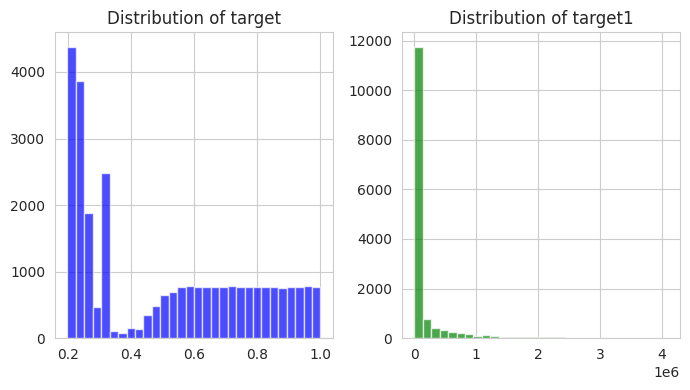

In [241]:

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(7, 4))  # 1 row, 2 columns

# Plot the first histogram
axes[0].hist(train_data['target'], bins=30, alpha=0.7, color='blue')
axes[0].set_title('Distribution of target')

# Plot the second histogram
axes[1].hist(train_data.query('target1 > 3')['target1'], bins=30, alpha=0.7, color='green')
axes[1].set_title('Distribution of target1')

# Show the plots
plt.tight_layout()
plt.show()


<Axes: >

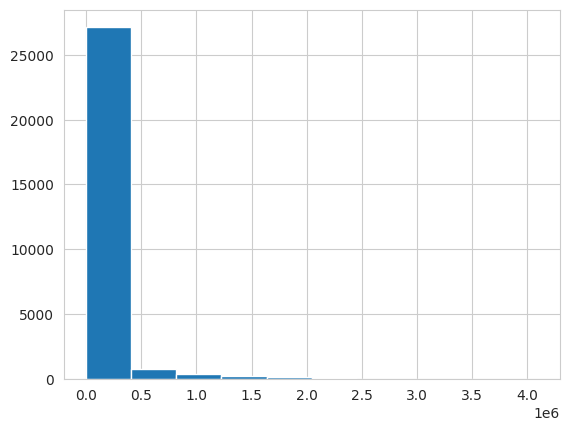

In [234]:
y.hist()

In [232]:
y[y<1].max() #.hist()

0.9884930849075317

In [213]:

# os.listdir()
class Config:
    model_round_ = 5
    state = 529
    n_splits = 5
    early_stop = 350
    target = "target"
    original_data = "N"
    outliers = "N"
    log_trf = "N"
    scaler_trf = "N"
    feature_eng = "Y"
    missing = "Y"
    submission = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv')

In [214]:
# value_counts =X[t.cat_features].apply(pd.Series.value_counts)
# # Plot histograms for each column
# for col in value_counts.columns:
#     plt.figure(figsize=(8, 4))
#     value_counts[col].dropna().plot(kind='bar', color='skyblue', edgecolor='black')
#     plt.title(f'Value Counts for {col}')
#     plt.xlabel('Categories')
#     plt.ylabel('Counts')
#     plt.xticks(rotation=45)
#     plt.show()


In [215]:
#models ydf

def YDFRegressor(learner_class):

    class YDFXRegressor(BaseEstimator, RegressorMixin):

        def __init__(self, params={}):
            self.params = params

        def fit(self, X, y):
            assert isinstance(X, pd.DataFrame)
            assert isinstance(y, pd.Series)
            target = y.name
            params = self.params.copy()
            params["label"] = target
            params["task"] = ydf.Task.REGRESSION
            X = pd.concat([X, y], axis=1)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(
                io.StringIO()
            ):
                self.model = learner_class(**params).train(X)
            return self

        def predict(self, X):
            assert isinstance(X, pd.DataFrame)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(
                io.StringIO()
            ):
                return self.model.predict(X)

    return YDFXRegressor


def build_model():
    
    x_input_cats = layers.Input(shape=(len(t.cat_features),))
    embs = []
    for j in range(len(t.cat_features)):
        e = layers.Embedding(
            input_dim = t.cat_features_card[j], 
            output_dim = int(np.ceil(np.sqrt(t.cat_features_card[j])))
        )
        x = e(x_input_cats[:, j])
        # x_j = layers.Lambda(lambda x: x[:, j])(x_input_cats)
        # x = e(x_j)
        x = layers.Flatten()(x)
        embs.append(x)
        # promt
    # [print(i ) for i in embs]
    x_input_nums = layers.Input(shape=(len(t.num_features),))
    x = layers.Concatenate(axis=-1)(embs + [x_input_nums])
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.15)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1)(x)

    model = keras.Model(inputs=[x_input_cats, x_input_nums], outputs=x)
    return model
# LSTM-based model
def build_model_lstm():
    x_input_cats = layers.Input(shape=(len(t.cat_features),))
    embs = []
    for j in range(len(t.cat_features)):
        e = layers.Embedding(t.cat_features_card[j], int(np.ceil(np.sqrt(t.cat_features_card[j]))))
        x = e(x_input_cats[:,j])
        # x_j = layers.Lambda(lambda x: x[:, j])(x_input_cats)
        # x = e(x_j)
        x = layers.Flatten()(x)
        embs.append(x)
    # print(embs)
    x_input_nums = layers.Input(shape=(len(t.num_features),))
    # Combine embeddings and numerical features
    x = layers.Concatenate(axis=-1)(embs+[x_input_nums])
    # Reshape for LSTM (adding time dimension)
    x = layers.Reshape((1, -1))(x)
    #--- 
    x = layers.Bidirectional(layers.LSTM(512, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(256, kernel_regularizer=regularizers.l2(0.01)))(x)
    x = layers.Dropout(0.2)(x)
    # Dense layers with batch normalization and dropout
    x = layers.Dense(512, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(512, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(1)(x)
    model = keras.Model(inputs=[x_input_cats, x_input_nums], outputs=x)
    return model

def transformer_block(x, num_heads=4, ff_dim=256, dropout=0.1):
    # Multi-head self-attention
    attn_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=x.shape[-1] // num_heads,
        dropout=dropout
    )(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    # Feed-forward network (as in original Transformer)
    ff_output = layers.Dense(ff_dim, activation="relu")(x)
    ff_output = layers.Dense(x.shape[-1])(ff_output)
    x = layers.Add()([x, ff_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x
    
def build_model_attention():
    # Fixed dimension for all embeddings/projections
    token_dim = 16  # Can be tuned (8-32 typical)
    num_heads = 4
    # ==== Inputs ============================================
    x_input_cats = layers.Input(shape=(len(t.cat_features),))
    x_input_nums = layers.Input(shape=(len(t.num_features),))
    # ==== Categorical Embeddings ============================
    embs = []
    for j in range(len(t.cat_features)):
        # Fixed embedding dimension for all categorical features
        e = layers.Embedding(
            input_dim=t.cat_features_card[j],
            output_dim=token_dim,
            embeddings_regularizer=regularizers.l2(1e-4)
        )
        # Reshape to (batch_size, 1, token_dim)
        emb = e(x_input_cats[:, j])
        # x_j = layers.Lambda(lambda x: x[:, j])(x_input_cats)
        # emb = e(x_j)
        emb = layers.Reshape((1, token_dim))(emb)
        embs.append(emb)
    
    # ==== Numerical Features ================================
    # Project numericals to same dimension as embeddings
    num_numerical = len(t.num_features)
    x_nums = layers.Dense(num_numerical * token_dim)(x_input_nums)
    x_nums = layers.Reshape((num_numerical, token_dim))(x_nums)
    
    # ==== Combine Tokens ====================================
    x = layers.Concatenate(axis=1)(embs + [x_nums])  # Shape: (batch, num_tokens, token_dim)
    
    # ==== Transformer Blocks ================================
    for _ in range(3):  # 2 transformer blocks (can increase)
        x = transformer_block(x, num_heads=num_heads, ff_dim=256)
    
    # ==== Feature Aggregation ===============================
    # x = layers.GlobalAveragePooling1D()(x)
    x = layers.Attention()([x, x])  # Multi-Head Attention Pooling
    x = layers.Flatten()(x)  # Keep more information
    # ==== Dense Head ========================================
    x = layers.Dense(256, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Dense(256, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(1)(x)
    # Create model
    model = keras.Model(inputs=[x_input_cats, x_input_nums], outputs=x)
    return model 

In [216]:
train_controler = True



models = {

    # "NN1": [_, train_controler],
    # "NN2": [_, train_controler],
    # "NN3": [_, train_controler],
    # "CAT": [
    #     CatBoostRegressor(
    #         **{
    #             "verbose": 0,
    #             "random_state": Config.state,
    #             "cat_features": t.cat_features,
    #             "early_stopping_rounds": Config.early_stop,
    #             "eval_metric": "RMSE",
    #             "n_estimators": 2000,
    #             "depth": 9,
    #             "min_data_in_leaf": 96,
    #             "l2_leaf_reg": 8.972890275248485,
    #             "bagging_temperature": 0.18658249870341914,
    #             "random_strength": 0.14106593468982453,
    #             "learning_rate": 0.01,
    #         }
    #     ),
    #     train_controler,
    # ],
    # "CAT3": [
    #     CatBoostRegressor(
    #         **{
    #             "verbose": 0,
    #             "random_state": Config.state,
    #             "cat_features": t.cat_features,
    #             "early_stopping_rounds": Config.early_stop,
    #             "eval_metric": "MAPE",
    #             "n_estimators": 2000,
    #             "learning_rate": 0.01,
    #             "depth": 8,
    #             "min_data_in_leaf": 99,
    #             "l2_leaf_reg": 7.7324870113971125,
    #             "bagging_temperature": 0.003232535109945575,
    #             "random_strength": 0.12145610701952099,
    #         }
    #     ),
    #     train_controler,
    # ],
    # "CAT5": [
    #     CatBoostRegressor(
    #         **{
    #             "depth": 7,
    #             "min_data_in_leaf": 59,
    #             "l2_leaf_reg": 6.485681470975604,
    #             "bagging_temperature": 0.728613892125684,
    #             "random_strength": 0.3565990691132947,
    #             "verbose": 0,
    #             "random_state": Config.state,
    #             "cat_features": t.cat_features,
    #             "early_stopping_rounds": Config.early_stop,
    #             "eval_metric": "MAPE",
    #             "n_estimators": 2000,
    #             "learning_rate": 0.01,
    #             "task_type": "CPU",
    #         }
    #     ),
    #     train_controler,
    # ],
 
    # "XGB2": [
    #     XGBRegressor(
    #         **{
    #             "tree_method": "hist",
    #             "n_estimators": 3200,
    #             "objective": "reg:squarederror",
    #             "random_state": Config.state,
    #             "enable_categorical": True,
    #             "verbosity": 0,
    #             "early_stopping_rounds": Config.early_stop,
    #             "eval_metric": "rmse",
    #             "booster": "gbtree",
    #             "max_depth": 13,
    #             "min_child_weight": 16,
    #             "subsample": 0.8172380854733758,
    #             "reg_alpha": 0.2734696712123178,
    #             "reg_lambda": 0.5865768393479154,
    #             "colsample_bytree": 0.9766164536195251,
    #             "n_jobs": -1,
    #             "learning_rate": 0.01,
    #             "n_jobs": -1,
    #         }
    #     ),
    #     train_controler,
    # ],
    # "XGB3": [
    #     XGBRegressor(
    #         **{
    #             "tree_method": "hist",
    #             "n_estimators": 3000,
    #             "learning_rate": 0.01,
    #             "objective": "reg:squarederror",
    #             "random_state": Config.state,
    #             "enable_categorical": True,
    #             "verbosity": 0,
    #             "early_stopping_rounds": Config.early_stop,
    #             "eval_metric": "mape",
    #             "booster": "gbtree",
    #             "max_depth": 3,
    #             "min_child_weight": 12,
    #             "subsample": 0.7720667996291699,
    #             "reg_alpha": 0.07869714859026081,
    #             "reg_lambda": 0.9577219578640989,
    #             "colsample_bytree": 0.9728085969282255,
    #             "n_jobs": -1,
    #         }
    #     ),
    #     train_controler,
    # ],
    # "XGB4": [
    #     XGBRegressor(
    #         **{
    #             "booster": "gbtree",
    #             "max_depth": 3,
    #             "min_child_weight": 12,
    #             "subsample": 0.800221370346261,
    #             "reg_alpha": 0.4571249607822852,
    #             "reg_lambda": 0.6572354640280187,
    #             "colsample_bytree": 0.9982441671154363,
    #             "n_jobs": -1,
    #             "tree_method": "hist",
    #             "n_estimators": 3000,
    #             "learning_rate": 0.01,
    #             "objective": "reg:squarederror",
    #             "random_state": Config.state,
    #             "enable_categorical": True,
    #             "verbosity": 0,
    #             "early_stopping_rounds": Config.early_stop,
    #             "eval_metric": "mape",
    #             "booster": "gbtree",
    #             "device": "cuda",
    #         }
    #     ),
    #     train_controler,
    # ],
    # "XGB5": [
    #     XGBRegressor(
    #         **{
    #             "booster": "gbtree",
    #             "max_depth": 3,
    #             "min_child_weight": 19,
    #             "subsample": 0.8065343833518619,
    #             "reg_alpha": 0.3577049940509907,
    #             "reg_lambda": 0.8560297700871249,
    #             "colsample_bytree": 0.9866141987520272,
    #             "objective": "reg:squarederror",
    #             "n_jobs": -1,
    #             "tree_method": "hist",
    #             "n_estimators": 3000,
    #             "learning_rate": 0.01,
    #             "random_state": Config.state,
    #             "enable_categorical": True,
    #             "verbosity": 0,
    #             "early_stopping_rounds": Config.early_stop,
    #             "eval_metric": "mape",
    #             "device": "cuda",
    #         }
    #     ),
    #     train_controler,
    # ],
    # "LGBM2": [
    #     LGBMRegressor(
    #         **{
    #             "random_state": Config.state,
    #             "early_stopping_round": Config.early_stop,
    #             "categorical_feature": t.cat_features,
    #             "verbose": -1,
    #             "boosting_type": "gbdt",
    #             "eval_metric": "rmse",
    #             "objective": "regression_l2",
    #             "n_estimators": 5000,
    #             "max_depth": 13,
    #             "num_leaves": 891,
    #             "min_child_samples": 16,
    #             "min_child_weight": 11,
    #             "colsample_bytree": 0.48639630433139497,
    #             "reg_alpha": 0.45496760242817474,
    #             "reg_lambda": 0.9669296995303693,
    #             "learning_rate": 0.01,
    #         }
    #     ),
    #     train_controler,
    # ],
    # "LGBM3": [
    #     LGBMRegressor(
    #         **{
    #             "random_state": Config.state,
    #             "early_stopping_round": Config.early_stop,
    #             "categorical_feature": t.cat_features,
    #             "verbose": -1,
    #             "boosting_type": "gbdt",
    #             "eval_metric": "rmse",
    #             "objective": "regression_l2",
    #             "n_estimators": 2000,
    #             "max_depth": 6,
    #             "num_leaves": 328,
    #             "min_child_samples": 10,
    #             "min_child_weight": 16,
    #             "colsample_bytree": 0.4893394195489041,
    #             "reg_alpha": 0.18334253987924942,
    #             "reg_lambda": 0.8328414321738785,
    #             "learning_rate": 0.01,
    #         }
    #     ),
    #     train_controler,
    # ],
    # "LGBM4": [
    #     LGBMRegressor(
    #         **{
    #             "objective": "regression_l2",
    #             "metric": "mape",
    #             "max_depth": 12,
    #             "num_leaves": 878,
    #             "min_child_samples": 29,
    #             "min_child_weight": 14,
    #             "colsample_bytree": 0.49788260207319734,
    #             "reg_alpha": 0.4747476308475839,
    #             "reg_lambda": 0.6960820486441526,
    #             "random_state": Config.state,
    #             "early_stopping_round": Config.early_stop,
    #             "categorical_feature": t.cat_features,
    #             "verbose": -1,
    #             "boosting_type": "gbdt",
    #             "eval_metric": "mape",
    #             "objective": "regression_l2",
    #             "n_estimators": 3000,
    #             "learning_rate": 0.01,
    #         }
    #     ),
    #     train_controler,
    # ],
    # "LGBM5": [
    #     LGBMRegressor(
    #         **{
    #             "objective": "regression_l2",
    #             "metric": "mape",
    #             "max_depth": 7,
    #             "num_leaves": 123,
    #             "min_child_samples": 21,
    #             "min_child_weight": 24,
    #             "colsample_bytree": 0.3641261996760593,
    #             "reg_alpha": 0.03632800166349373,
    #             "reg_lambda": 0.5287861861476272,
    #             "random_state": Config.state,
    #             "early_stopping_round": Config.early_stop,
    #             "categorical_feature": t.cat_features,
    #             "verbose": -1,
    #             "boosting_type": "gbdt",
    #             "n_estimators": 3000,
    #             "learning_rate": 0.01,
    #         }
    #     ),
    #     train_controler,
    # ],
    # "LGBM6": [
    #     LGBMRegressor(
    #         **{
    #             "objective": "regression_l2",
    #             "metric": "mape",
    #             "max_depth": 6,
    #             "num_leaves": 502,
    #             "min_child_samples": 23,
    #             "min_child_weight": 18,
    #             "colsample_bytree": 0.4714820876493163,
    #             "reg_alpha": 0.054972003081022576,
    #             "reg_lambda": 0.5774608955362155,
    #             "random_state": Config.state,
    #             "early_stopping_round": Config.early_stop,
    #             "categorical_feature": t.cat_features,
    #             "verbose": -1,
    #             "boosting_type": "goss",
    #             "n_estimators": 3000,
    #             "learning_rate": 0.01,
    #         }
    #     ),
    #     train_controler,
    # ],
    # "LGBM7": [
    #     LGBMRegressor(
    #         **{
    #             "objective": "regression_l2",
    #             "metric": "mape",
    #             "max_depth": 14,
    #             "num_leaves": 279,
    #             "min_child_samples": 7,
    #             "min_child_weight": 24,
    #             "colsample_bytree": 0.43218993309765835,
    #             "reg_alpha": 0.42757392987472964,
    #             "reg_lambda": 0.9039762787446107,
    #             "random_state": Config.state,
    #             "early_stopping_round": Config.early_stop,
    #             "categorical_feature": t.cat_features,
    #             "verbose": -1,
    #             "boosting_type": "goss",
    #             "n_estimators": 3000,
    #             "learning_rate": 0.01,
    #         }
    #     ),
    #     train_controler,
    # ],

    ##### "RF": [RandomForestRegressor(n_estimators=100), train_controler],
    "Ridge": [Ridge(tol=1e-5, max_iter=1000000, random_state=Config.state), train_controler],
    "BRidge": [BayesianRidge(tol=1e-5, ), train_controler],
    "LR": [LinearRegression(), train_controler],
    "HGB": [
        HistGradientBoostingRegressor(
            **{
                "max_depth": 4,
                "loss": "squared_error",
                "l2_regularization": 0.014082438341668873,
                "min_samples_leaf": 39,
                "max_leaf_nodes": 25,
                "learning_rate": 0.01,
                "max_iter": 2000,
                "random_state": Config.state,
                "early_stopping": "auto",
            }
        ),
        train_controler,
    ],
    # "HGB2": [
    #     HistGradientBoostingRegressor(
    #         **{
    #             "max_depth": 4,
    #             "loss": "squared_error",
    #             "l2_regularization": 1.0294569289519551e-05,
    #             "min_samples_leaf": 12,
    #             "max_leaf_nodes": 26,
    #             "learning_rate": 0.01,
    #             "max_iter": 2000,
    #             "random_state": Config.state,

    #             "early_stopping": "auto",
    #         }
    #     ),
    #     train_controler,
    # ],

    # "HGB3": [
    #     HistGradientBoostingRegressor(

    #         **{
    #             "max_depth": 13,
    #             "loss": "squared_error",
    #             "l2_regularization": 0.05253480068908677,
    #             "min_samples_leaf": 19,
    #             "max_leaf_nodes": 40,
    #             "learning_rate": 0.01,
    #             "max_iter": 3000,
    #             "random_state": Config.state,

    #             "early_stopping": "auto",
    #         }
    #     ),
    #     train_controler,
    # ],

    # "HGB4": [
    #     HistGradientBoostingRegressor(

    #         **{
    #             "max_depth": 4,
    #             "loss": "squared_error",
    #             "l2_regularization": 1.3248236291502028e-09,
    #             "min_samples_leaf": 39,
    #             "max_leaf_nodes": 29,
    #             "learning_rate": 0.01,
    #             "max_iter": 3000,
    #             "random_state": Config.state,

    #             "early_stopping": "auto",
    #         }
    #     ),
    #     train_controler,
    # ],

    # "YDF": [
    #     YDFRegressor(GradientBoostedTreesLearner)(
    #         {
    #             "num_trees": 1000,
    #             "max_depth": 13,
    #         }
    #     ),
    #     train_controler,
    # ],
}

In [217]:
# unity check on cats card, 
for j in range(len(t.cat_features)):
    # print(j)
    unique_values = test_enc[t.cat_features[j]].unique()
    # print(f"Feature {t.cat_features[j]}: Unique values = {unique_values}")
    assert min(unique_values) >= 0, ''
    assert max(unique_values) < t.cat_features_card[j], ''
t.cat_features == t.cat_features

True

In [218]:
class Model(Config):

    def __init__(self, X, X_enc, y, test, test_enc, models):
        self.y = y
        self.models = models
        self.scores = pd.DataFrame(columns=['Score'])
        self.OOF_preds = pd.DataFrame()
        self.TEST_preds = pd.DataFrame()
        self.folds = KFold(n_splits=self.n_splits)
        self.model = None
        self.model_dir = './models/'

    def train(self):      
        
        for model_name, [model, training] in tqdm(self.models.items()):
            if training:
                print('='*20)
                print(model_name)
                if any(model in model_name for model in ['LGBM', 'CAT', 'XGB']):
                    self.X = X
                    self.test = test
                else:
                    self.X = X_enc
                    self.test = test_enc
                if re.findall('NN', model_name):
                    for n_fold, (train_id, valid_id) in enumerate(
                        self.folds.split(self.X, self.y, groups=X["race_group"])
                    ):

                        X_train_cats = self.X.loc[train_id, t.cat_features]
                        X_train_nums = self.X.loc[train_id, t.num_features]
                        y_train = self.y.loc[train_id].values

                        X_val_cats = self.X.loc[valid_id, t.cat_features]
                        X_val_nums = self.X.loc[valid_id, t.num_features]
                        y_val = self.y.loc[valid_id]

                        X_test_cats = self.test[t.cat_features]
                        X_test_nums = self.test[t.num_features]

                        oof_preds = pd.DataFrame(columns=[model_name], index=X_val_cats.index)
                        test_preds = pd.DataFrame(columns=[model_name], index=test.index)
                        print(f'Fold {n_fold+1}')

                        if model_name == 'NN1':
                            model = build_model()
                        if model_name == 'NN2':
                            model = build_model_lstm() #b
                        if model_name == 'NN3':
                            model = build_model_attention() #b
                        keras.utils.set_random_seed(self.state)
                        optimizer = keras.optimizers.Adam(learning_rate=1e-3)
                        model.compile(optimizer=optimizer, loss='mean_squared_error')
                        model.fit([X_train_cats,X_train_nums], y_train, 
                                  validation_data=([X_val_cats, X_val_nums], y_val),
                                  epochs=21,
                                  batch_size=1000,
                                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=1),
                                             keras.callbacks.EarlyStopping(patience=3),
                                             tensorboard_callback
                                            ])

                        y_pred_val = model.predict([X_val_cats, X_val_nums])
                        test_pred = model.predict([X_test_cats, X_test_nums])
                        self.model = model

                        score = mean_absolute_percentage_error(y_val, y_pred_val)
                        print(score)
                        self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = score

                        oof_preds[model_name] = y_pred_val
                        test_preds[model_name] = test_pred

                        self.OOF_preds  = pd.concat([self.OOF_preds, oof_preds], axis = 0, ignore_index = False)
                        self.TEST_preds = pd.concat([self.TEST_preds, test_preds], axis = 0, ignore_index = False)

                        # Save the model to a file locally
                        model_save_path = f"{self.model_dir}/{model_name}_fold{n_fold+1}.h5"
                        # model.save(model_save_path)
                else:
                    for n_fold, (train_id, valid_id) in enumerate(
                        self.folds.split(self.X, self.y, groups=self.X["race_group"])
                    ):
                        X_train, y_train = self.X.iloc[train_id], self.y.iloc[train_id]
                        X_val, y_val = self.X.iloc[valid_id], self.y.iloc[valid_id]

                        oof_preds = pd.DataFrame(columns=[model_name], index=X_val.index)
                        test_preds = pd.DataFrame(columns=[model_name], index=test.index)
                        print(f'Fold {n_fold+1}')

                        if "XGB" in model_name:
                            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
                            self.model = model
                            model_save_path = f"{self.model_dir}/{model_name}_fold{n_fold+1}.json"
                            # model.save_model(model_save_path)

                        elif "CAT" in model_name:
                            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
                            self.model = model
                            model_save_path = f"{self.model_dir}/{model_name}_fold{n_fold+1}.cbm"
                            # model.save_model(model_save_path)

                        elif "LGBM" in model_name:
                            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[log_evaluation(0), early_stopping(self.early_stop, verbose=False)])
                            self.model = model
                            model_save_path = f"{self.model_dir}/{model_name}_fold{n_fold+1}.txt"
                            # model.booster_.save_model(model_save_path)  # Use the booster_ attribute

                        else:
                            model.fit(X_train, y_train)
                            self.model = model
                            model_save_path = f"{self.model_dir}/{model_name}_fold{n_fold+1}.h5"
                            # model.save(model_save_path)

                        y_pred_val = model.predict(X_val)
                        test_pred = model.predict(self.test)

                        score = mean_absolute_percentage_error(y_val, y_pred_val)
                        print(score)
                        self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = score

                        oof_preds[model_name] = y_pred_val
                        test_preds[model_name] = test_pred
                        self.OOF_preds = pd.concat([self.OOF_preds, oof_preds], axis = 0, ignore_index = False)
                        self.TEST_preds = pd.concat([self.TEST_preds, test_preds], axis = 0, ignore_index = False)

                self.OOF_preds = self.OOF_preds.groupby(level=0).mean()
                self.TEST_preds = self.TEST_preds.groupby(level=0).mean()
                try:
                    self.result_all(model_name)
                except Exception as e:
                    print(e)
                self.OOF_preds[f'{model_name}'].to_csv(f'./submission_0/submissions_{Config.model_round_}/{model_name}_oof.csv', index=False)
                self.TEST_preds[f'{model_name}'].to_csv(f'./submission_0/submissions_{Config.model_round_}/{model_name}_test.csv', index=False)

            else:
                self.OOF_preds[f'{model_name}'] = pd.read_csv(f'./submission_0/submissions_{Config.model_round_}/{model_name}_oof.csv')
                self.TEST_preds[f'{model_name}'] = pd.read_csv(f'./submission_0/submissions_{Config.model_round_}/{model_name}_test.csv')

                for n_fold, (train_id, valid_id) in enumerate(self.folds.split(self.OOF_preds[f'{model_name}'], self.y, groups = X['year'])):
                    y_pred_val, y_val = self.OOF_preds[f'{model_name}'].iloc[valid_id], self.y.iloc[valid_id]
                    self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = mean_absolute_percentage_error(y_val, y_pred_val)

            self.scores.loc[f'{model_name}', 'Score'] = self.scores.loc[f'{model_name}'][1:].mean()
        self.scores.loc['Ensemble'], self.OOF_preds["Ensemble"], self.TEST_preds["Ensemble"] = self.ensemble(self.OOF_preds, self.y, self.TEST_preds)
        self.scores = self.scores.sort_values('Score')

        self.result()

        return self.TEST_preds

    def ensemble(self, X, y, test):
        scores = []
        oof_pred = np.zeros(X.shape[0])
        test_pred = np.zeros(test.shape[0])
        feature_importances = np.zeros(X.shape[1])
        model = BayesianRidge()
        kf = KFold(n_splits=self.n_splits, random_state=self.state, shuffle=True)

        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            model.fit(X_train, y_train)

            feature_importances += np.abs(model.coef_) / self.n_splits
            y_pred_probs = model.predict(X_val)
            oof_pred[val_idx] = y_pred_probs
            test_pred += model.predict(test) / self.n_splits

            score = mean_absolute_percentage_error(y_val, y_pred_probs)
            scores.append(score)
        feature_importances = feature_importances / np.sum(feature_importances)
        print(feature_importances)
        return np.mean(scores), oof_pred, test_pred

    def result(self):

        plt.figure(figsize=(14, 6))
        colors = ['#3cb371' if i != 'Ensemble' else 'r' for i in self.scores.Score.index]
        hbars = plt.barh(self.scores.index, self.scores.Score, color=colors, height=0.8)
        plt.bar_label(hbars, fmt='%.5f')
        plt.ylabel('Models')
        plt.xlabel('Score')              
        plt.show()

        y = self.y.sort_index()
        self.OOF_preds['Ensemble'] = self.OOF_preds['Ensemble'].sort_index()
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        axes[0].scatter(y, self.OOF_preds['Ensemble'], alpha=0.5, s=15, edgecolors='#3cb371')
        axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
        axes[0].set_xlabel('Actual')
        axes[0].set_ylabel('Predicted')
        axes[0].set_title('Actual vs. Predicted')

        axes[1].scatter(self.OOF_preds['Ensemble'], y - self.OOF_preds['Ensemble'], alpha=0.5, s=15, edgecolors='#3cb371')
        axes[1].axhline(y=0, color='black', linestyle='--', lw=2)
        axes[1].set_xlabel('Predicted Values')
        axes[1].set_ylabel('Residuals')
        axes[1].set_title('Residual Plot')

        plt.tight_layout()
        plt.show()

    def result_all(self, model_name):
    
        y = self.y.sort_index()
        self.OOF_preds[f'{model_name}'] = self.OOF_preds[f'{model_name}'].sort_index()
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        axes[0].scatter(y, self.OOF_preds[f'{model_name}'], alpha=0.5, s=15, edgecolors='#3cb371')
        axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
        axes[0].set_xlabel('Actual')
        axes[0].set_ylabel('Predicted')
        axes[0].set_title('Actual vs. Predicted')
    
        axes[1].scatter(self.OOF_preds[f'{model_name}'], y - self.OOF_preds[f'{model_name}'], alpha=0.5, s=15, edgecolors='#3cb371')
        axes[1].axhline(y=0, color='black', linestyle='--', lw=2)
        axes[1].set_xlabel('Predicted Values')
        axes[1].set_ylabel('Residuals')
        axes[1].set_title('Residual Plot')
    
        plt.tight_layout()
        plt.show()

In [219]:
X.columns[X.dtypes.apply( lambda x: x not in ['category','float32', 'int8'])]

Index([], dtype='object')

  0%|          | 0/4 [00:00<?, ?it/s]

Ridge
Fold 1
264008827348.0481
Fold 2
42139553412.30626
Fold 3
410332981098.56573
Fold 4
667314434497.3378
Fold 5
335235637050.2148
Fold 6
356130024578.29315
Fold 7
268220140564.45282
Fold 8
1.8798059627571306
Fold 9
411090044385.87335
Fold 10
646747754616.6711
Fold 11
319910573914.0725
Fold 12
229723991701.71677
Fold 13
450725747800.5639
Fold 14
215622089930.1282
Fold 15
413943683205.05054
Fold 16
232290441776.5237
Fold 17
340074756676.90845
Fold 18
565060583657.2228
Fold 19
418724577136.63135
Fold 20
242096647409.40524
Fold 21
173380309262.43222
Fold 22
231774929422.52548
Fold 23
355144519560.2377
Fold 24
473859821608.15063
Fold 25
516220453276.744
Fold 26
380934213745.4102
Fold 27
221668843771.53497
Fold 28
90184347389.6174
Fold 29
1104804898990.5825
Fold 30
1.7442577365029788
Fold 31
26371424872.1134
Fold 32
382340134208.24097
Fold 33
249064408728.34485
Fold 34
126712478754.86789
Fold 35
885503164369.7015
Fold 36
471812716754.9221
Fold 37
401198104391.5604
Fold 38
9879639475.64207


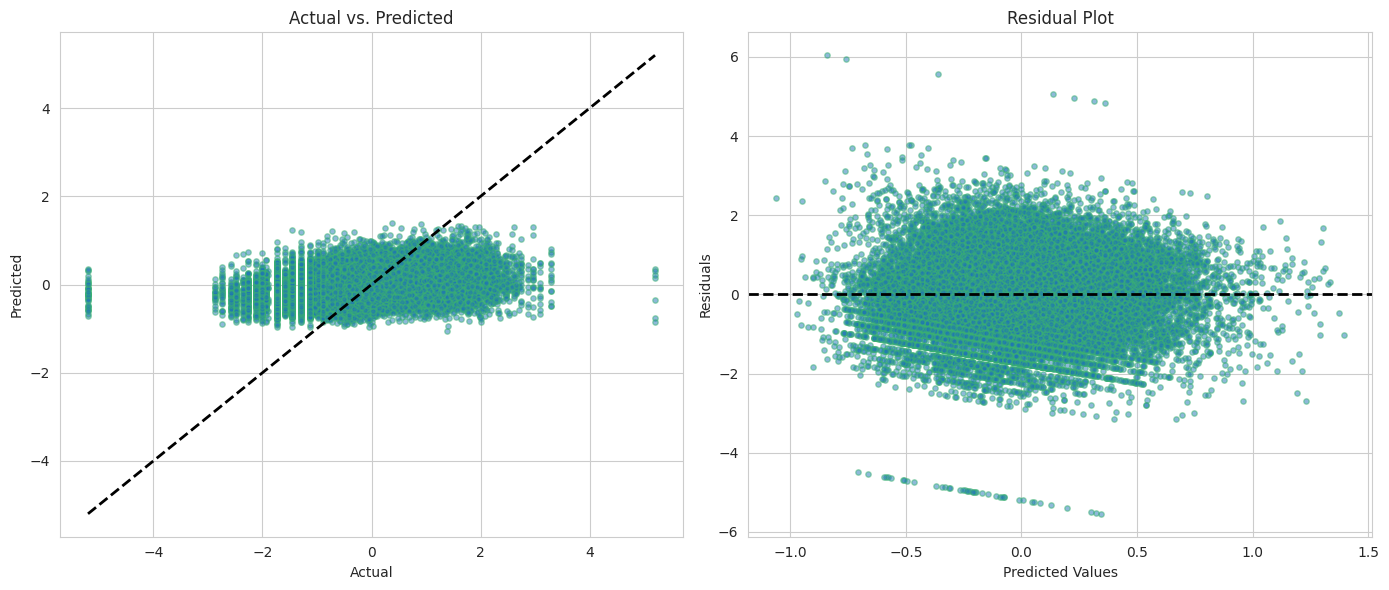

 25%|██▌       | 1/4 [00:02<00:08,  2.74s/it]

BRidge
Fold 1
321164924119.9293
Fold 2
191824533071.99155
Fold 3
219094873538.81784
Fold 4
175321475192.64114
Fold 5
994045833758.0034
Fold 6
410771635131.6257
Fold 7
17030110010.644236
Fold 8
197985272066.0623
Fold 9
747193150017.2667
Fold 10
468537062733.54877
Fold 11
668368483843.542
Fold 12
1.8105858676521722
Fold 13
563181720302.7439
Fold 14
476935141498.61755
Fold 15
138151019457.22964
Fold 16
1.6737426665897128
Fold 17
197436747637.8867
Fold 18
614147969959.3546
Fold 19
925055956140.7343
Fold 20
1.8240259064214772
Fold 21
1.6392540013500627
Fold 22
210155458900.26584
Fold 23
656683410587.1602
Fold 24
132140428254.80002
Fold 25
750998173885.5612
Fold 26
2.0221032572886504
Fold 27
312492572192.4107
Fold 28
336765297666.9237
Fold 29
975221969112.0906
Fold 30
259631765113.15533
Fold 31
653472608928.6047
Fold 32
221659733386.14844
Fold 33
134393004061.72168
Fold 34
465391232152.3136
Fold 35
330177137741.7112
Fold 36
209503482639.08566
Fold 37
1.8008898438500283
Fold 38
462529931897.0

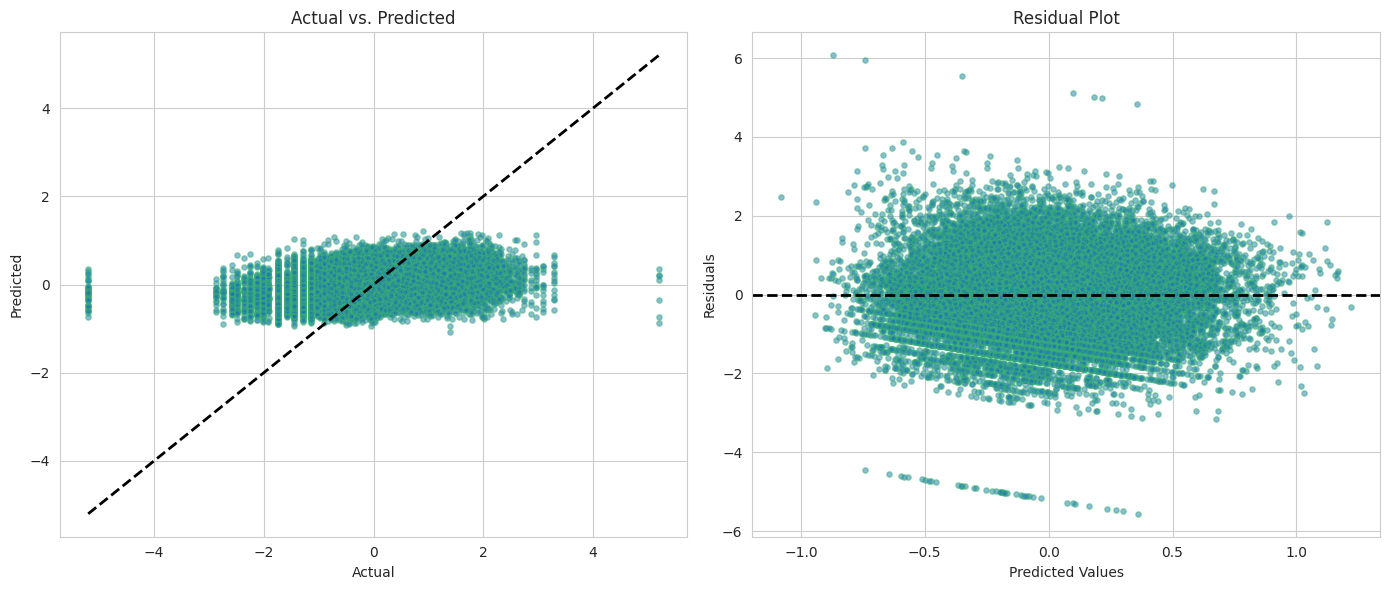

 50%|█████     | 2/4 [00:07<00:08,  4.07s/it]

LR
Fold 1
129002653702.32526
Fold 2
269937765251.81412
Fold 3
671420685128.6211
Fold 4
218746150059.88156
Fold 5
528653107275.1281
Fold 6
392333595177.81964
Fold 7
912422248328.05
Fold 8
183094612907.78723
Fold 9
175829206887.67664
Fold 10
26773679406.924816
Fold 11
187069686672.0614
Fold 12
1052372090197.9073
Fold 13
219808234211.63876
Fold 14
313405730800.75836
Fold 15
210370807602.73764
Fold 16
1.735673041455943
Fold 17
586298913645.4446
Fold 18
262637250152.26645
Fold 19
691568420259.2021
Fold 20
186901765525.99728
Fold 21
617963131977.283
Fold 22
254237625387.68842
Fold 23
1.9169727293331764
Fold 24
509295298729.13855
Fold 25
414527765695.1891
Fold 26
204627913981.57928
Fold 27
181876115826.01352
Fold 28
772469920197.8217
Fold 29
52704238208.48253
Fold 30
544942545261.9105
Fold 31
2.1321042827144323
Fold 32
282778503440.91754
Fold 33
34986888698.87593
Fold 34
414776149013.8939
Fold 35
967943706000.8243
Fold 36
197594561770.9403
Fold 37
221853122129.1953
Fold 38
532957719576.6408
F

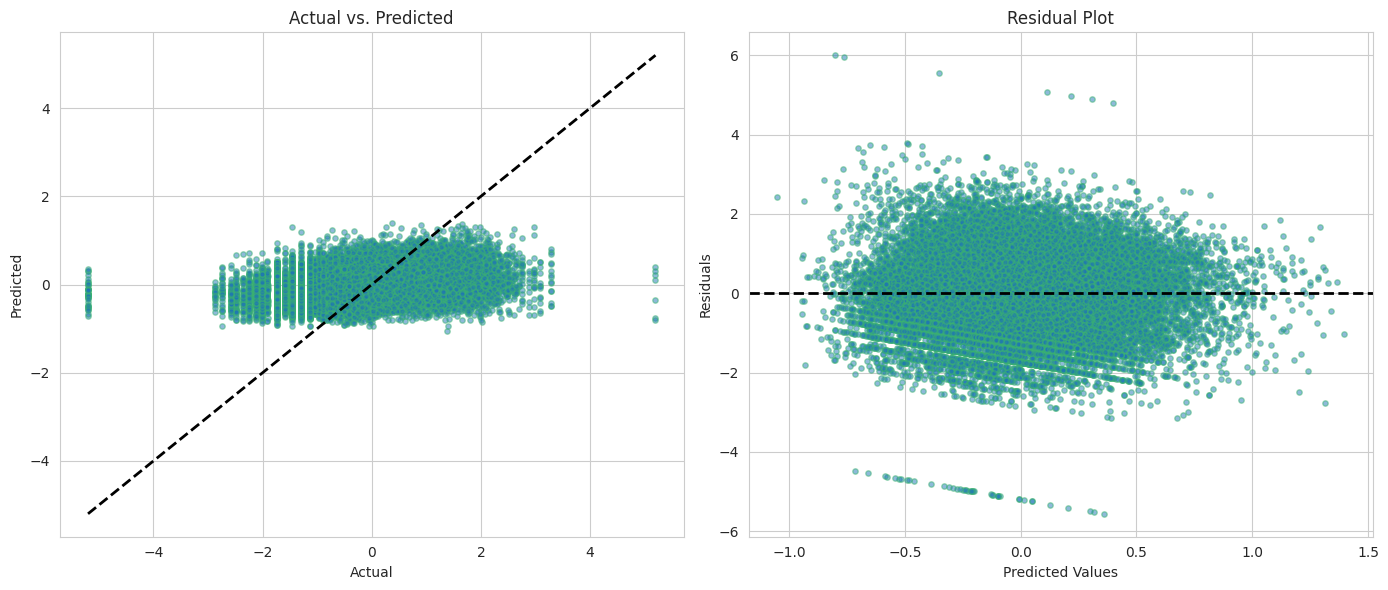

 75%|███████▌  | 3/4 [00:12<00:04,  4.52s/it]

HGB
Fold 1
578264847909.5745
Fold 2
67608026285.4053
Fold 3
146794856813.21277
Fold 4
67106249173.65293
Fold 5
414012461580.4073
Fold 6
2.1438279284674993
Fold 7
973562180214.2598
Fold 8
313841454848.40356
Fold 9
33403661825.439617
Fold 10
389698224851.6186
Fold 11
2.2256204023511943
Fold 12
376517547289.19305
Fold 13
463516759336.3477
Fold 14


 75%|███████▌  | 3/4 [01:51<00:37, 37.01s/it]


KeyboardInterrupt: 

In [220]:
import os
from tqdm import tqdm
import re
Config.model_round_ = 6
try:
    os.listdir(f'./submission_0/submissions_{Config.model_round_}')
except:
    os.makedirs(f'./submission_0/submissions_{Config.model_round_}')
try:
    model = Model(X, X_enc, y, test, test_enc, models)
    TEST_preds = model.train()
    submission = Config.submission
    submission['prediction'] =TEST_preds['Ensemble'].values
    submission.to_csv(f'./submission.csv', index=False)
    model.TEST_preds.to_csv(f'./submission_allmodel.csv', index=False)

except Exception as e:
    # from samoyan_pack.messenger1 import messenger1
    # messenger1("s51 err: " + str(e))
    print(e)
    raise e

In [ ]:
def inv_trns(x):
    x = x.to_numpy().reshape(-1,1)
    return scaler_pw.inverse_transform(x)
mean_absolute_percentage_error(inv_trns(model.OOF_preds['Ensemble'] ), inv_trns(y))

#.apply(inv_trns )

In [155]:
model.OOF_preds

,Ridge,BRidge,LR,HGB,Ensemble
0,-0.417645,-0.454593,-0.429024,-0.684404,-0.736841
1,0.192879,0.227195,0.180748,0.041453,0.004840
2,-0.545431,-0.546245,-0.532310,-0.817385,-0.889331
3,-0.049865,-0.036434,-0.046052,0.284770,0.345023
4,-0.026668,-0.055214,-0.036733,0.165389,0.205554
...,...,...,...,...,...
28795,-0.040034,0.066587,0.012783,-0.073107,-0.103024
28796,0.221341,0.225597,0.217006,0.734614,0.839139
28797,0.275340,0.329724,0.290122,0.501113,0.541280
28798,-0.216121,-0.209843,-0.236517,-0.406196,-0.455813


In [29]:
# !kaggle kernels pull fyenneyenn/cibmtr-eda-ensemble-model
os.listdir("/kaggle/working/submission_0/")

['submissions_6', 'output.zip']

In [34]:
import shutil

# Path to the directory or file you want to zip
path_to_zip = "/kaggle/working/submission_0/submissions_6"

# Path for the output ZIP file
output_zip_path = "/kaggle/working/logs/outpu1t.zip"

# Create a ZIP file
shutil.make_archive(output_zip_path.replace(".zip", ""), "zip", path_to_zip)

print(f"ZIP file created at: {output_zip_path}")

ZIP file created at: /kaggle/working/logs/outpu1t.zip


<p style="background-color: rgb(247, 230, 202); font-size: 300%; text-align: center; border-radius: 40px 40px; color: rgb(162, 87, 79); font-weight: bold; font-family: 'Roboto'; border: 4px solid rgb(162, 87, 79);">Model Development</p>

In [ ]:
class EDA:
    
    def __init__(self, colorscale, color, data):
        self._colorscale = colorscale
        self._color = color  
        self.data = data

    def _template(self, fig, title):
        
        fig.update_layout(
            title=title,
            title_x=0.5, 
            plot_bgcolor='rgba(247, 230, 202, 1)',  
            paper_bgcolor='rgba(247, 230, 202, 1)', 
            font=dict(color=self._color),
            margin=dict(l=72, r=72, t=72, b=72), 
            height=720
        )
        
        return fig

    def distribution_plot(self, col, title):
        
        fig = px.histogram(
            self.data,
            x=col,
            nbins=100,
            color_discrete_sequence=[self._color]
        )
        
        fig.update_layout(
            xaxis_title='Values',
            yaxis_title='Count',
            bargap=0.1,
            xaxis=dict(gridcolor='grey'),
            yaxis=dict(gridcolor='grey', zerolinecolor='grey')
        )
        
        fig.update_traces(hovertemplate='Value: %{x:.2f}<br>Count: %{y:,}')
        
        fig = self._template(fig, f'{title}')
        fig.show()
    
    def bar_chart(self, col):
        
        value_counts = self.data[col].value_counts().reset_index()
        value_counts.columns = [col, 'count']
        
        fig = px.bar(
            value_counts,
            y=col,
            x='count',
            orientation='h',
            color='count',
            color_continuous_scale=self._colorscale,
        )
        
        fig.update_layout(
            xaxis_title='Count',
            yaxis_title='',
            xaxis=dict(gridcolor='grey'),
            yaxis=dict(gridcolor='grey', zerolinecolor='grey')
        )
        
        fig.update_traces(
            hovertemplate=(
                f'<b>{col}:</b> %{{y}}<br>'
                '<b>Count:</b> %{x:,}<br>'
            ),
            hoverlabel=dict(
                font=dict(color=self._color),
                bgcolor='rgba(247, 230, 202, 1)'
            )
        )
        
        fig = self._template(fig, f'{col}')
        fig.show()
        
    def _plot_cv(self, scores, title, metric='Stratified C-Index'):
        
        fold_scores = [round(score, 3) for score in scores]
        mean_score = round(np.mean(scores), 3)

        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x = list(range(1, len(fold_scores) + 1)),
            y = fold_scores,
            mode = 'markers', 
            name = 'Fold Scores',
            marker = dict(size = 27, color=self._color, symbol='diamond'),
            text = [f'{score:.3f}' for score in fold_scores],
            hovertemplate = 'Fold %{x}: %{text}<extra></extra>',
            hoverlabel = dict(font=dict(size=18))  
        ))

        fig.add_trace(go.Scatter(
            x = [1, len(fold_scores)],
            y = [mean_score, mean_score],
            mode = 'lines',
            name = f'Mean: {mean_score:.3f}',
            line = dict(dash = 'dash', color = '#B22222'),
            hoverinfo = 'none'
        ))
        
        fig.update_layout(
            title = f'{title} | Cross-validation Mean {metric} Score: {mean_score}',
            xaxis_title = 'Fold',
            yaxis_title = f'{metric} Score',
            plot_bgcolor = 'rgba(247, 230, 202, 1)',  
            paper_bgcolor = 'rgba(247, 230, 202, 1)',
            font = dict(color=self._color), 
            xaxis = dict(
                gridcolor = 'grey',
                tickmode = 'linear',
                tick0 = 1,
                dtick = 1,
                range = [0.5, len(fold_scores) + 0.5],
                zerolinecolor = 'grey'
            ),
            yaxis = dict(
                gridcolor = 'grey',
                zerolinecolor = 'grey'
            )
        )
        
        fig.show()

In [ ]:
# EDA(CFG.colorscale, CFG.color, train_data)

In [ ]:
class MD:
    
    def __init__(self, colorscale, color, data, cat_cols, early_stop, penalizer, n_splits):
        
        self.eda = EDA(colorscale, color, data)
        self.targets = Targets(data, cat_cols, penalizer, n_splits)
        
        self.data = data
        self.cat_cols = cat_cols
        self._early_stop = early_stop

    def create_targets(self):

        self.data = self.targets.create_target1()
        self.data = self.targets.create_target2()
        self.data = self.targets.create_target3()
        self.data = self.targets.create_target4()

        return self.data
        
    def train_model(self, params, target, title):
        
        for col in self.cat_cols:
            self.data[col] = self.data[col].astype('category')
            
        X = self.data.drop(['ID', 'efs', 'efs_time', 'target1', 'target2', 'target3', 'target4'], axis=1)
        y = self.data[target]
        
        models, fold_scores = [], []
            
        cv, oof_preds = self.targets._prepare_cv()
    
        for fold, (train_index, valid_index) in enumerate(cv.split(X, y)):
                
            X_train = X.iloc[train_index]
            X_valid = X.iloc[valid_index]
                
            y_train = y.iloc[train_index]
            y_valid = y.iloc[valid_index]
    
            if title.startswith('LightGBM'):
                        
                model = lgb.LGBMRegressor(**params)
                        
                model.fit(
                    X_train, 
                    y_train,  
                    eval_set=[(X_valid, y_valid)],
                    eval_metric='rmse',
                    callbacks=[lgb.early_stopping(self._early_stop, verbose=0), lgb.log_evaluation(0)]
                )
                        
            elif title.startswith('CatBoost'):
                        
                model = CatBoostRegressor(**params, verbose=0, cat_features=self.cat_cols)
                        
                model.fit(
                    X_train,
                    y_train,
                    eval_set=(X_valid, y_valid),
                    early_stopping_rounds=self._early_stop, 
                    verbose=0
                )               
                    
            models.append(model)
                
            oof_preds[valid_index] = model.predict(X_valid)

            y_true_fold = self.data.iloc[valid_index][['ID', 'efs', 'efs_time', 'race_group']].copy()
            y_pred_fold = self.data.iloc[valid_index][['ID']].copy()
            
            y_pred_fold['prediction'] = oof_preds[valid_index]
    
            fold_score = score(y_true_fold, y_pred_fold, 'ID')
            fold_scores.append(fold_score)
    
        self.eda._plot_cv(fold_scores, title)
        self.targets.validate_model(oof_preds, title)
        
        return models, oof_preds

    def infer_model(self, data, models):
        
        data = data.drop(['ID'], axis=1)

        for col in self.cat_cols:
            data[col] = data[col].astype('category')

        return np.mean([model.predict(data) for model in models], axis=0)

In [ ]:
# train_data

<p style="background-color: rgb(247, 230, 202); font-size: 300%; text-align: center; border-radius: 40px 40px; color: rgb(162, 87, 79); font-weight: bold; font-family: 'Roboto'; border: 4px solid rgb(162, 87, 79);">Models with Cox Target</p>

In [ ]:
# ctb1_models, ctb1_oof_preds = md.train_model(CFG.ctb_params, target='target1', title='CatBoost')

In [ ]:
# lgb1_models, lgb1_oof_preds = md.train_model(CFG.lgb_params, target='target1', title='LightGBM')

In [ ]:
# ctb1_preds = md.infer_model(test_data, ctb1_models)

In [ ]:
# lgb1_preds = md.infer_model(test_data, lgb1_models)

<p style="background-color: rgb(247, 230, 202); font-size: 300%; text-align: center; border-radius: 40px 40px; color: rgb(162, 87, 79); font-weight: bold; font-family: 'Roboto'; border: 4px solid rgb(162, 87, 79);">Models with Kaplan-Meier Target</p>

In [ ]:
# ctb2_models, ctb2_oof_preds = md.train_model(CFG.ctb_params, target='target2', title='CatBoost')

In [ ]:
# lgb2_models, lgb2_oof_preds = md.train_model(CFG.lgb_params, target='target2', title='LightGBM')

In [ ]:
# ctb2_preds = md.infer_model(test_data, ctb2_models)

In [ ]:
# lgb2_preds = md.infer_model(test_data, lgb2_models)

<p style="background-color: rgb(247, 230, 202); font-size: 300%; text-align: center; border-radius: 40px 40px; color: rgb(162, 87, 79); font-weight: bold; font-family: 'Roboto'; border: 4px solid rgb(162, 87, 79);">Models with Nelson-Aalen Target</p>

In [ ]:
# ctb3_models, ctb3_oof_preds = md.train_model(CFG.ctb_params, target='target3', title='CatBoost')

In [ ]:
# lgb3_models, lgb3_oof_preds = md.train_model(CFG.lgb_params, target='target3', title='LightGBM')

In [ ]:
# ctb3_preds = md.infer_model(test_data, ctb3_models)

In [ ]:
# lgb3_preds = md.infer_model(test_data, lgb3_models)

<p style="background-color: rgb(247, 230, 202); font-size: 300%; text-align: center; border-radius: 40px 40px; color: rgb(162, 87, 79); font-weight: bold; font-family: 'Roboto'; border: 4px solid rgb(162, 87, 79);">Models with Cox-Loss Target</p>

In [ ]:
# cox1_models, cox1_oof_preds = md.train_model(CFG.cox1_params, target='target4', title='CatBoost')

In [ ]:
# cox2_models, cox2_oof_preds = md.train_model(CFG.cox2_params, target='target4', title='CatBoost')

In [ ]:
# cox1_preds = md.infer_model(test_data, cox1_models)

In [ ]:
# cox2_preds = md.infer_model(test_data, cox2_models)

<p style="background-color: rgb(247, 230, 202); font-size: 300%; text-align: center; border-radius: 40px 40px; color: rgb(162, 87, 79); font-weight: bold; font-family: 'Roboto'; border: 4px solid rgb(162, 87, 79);">Ensemble Model</p>

In [ ]:
oof_preds = [
    ctb1_oof_preds, 
    lgb1_oof_preds, 
    ctb2_oof_preds, 
    lgb2_oof_preds, 
    ctb3_oof_preds, 
    lgb3_oof_preds, 
    cox1_oof_preds,
    cox2_oof_preds
]

In [ ]:
preds = [
    ctb1_preds, 
    lgb1_preds, 
    ctb2_preds, 
    lgb2_preds, 
    ctb3_preds, 
    lgb3_preds,
    cox1_preds,
    cox2_preds
]

<div style="background-color: rgb(247, 230, 202); border: 4px solid rgb(162, 87, 79); border-radius: 40px; padding: 20px; font-family: 'Roboto'; color: rgb(162, 87, 79); text-align: left; font-size: 140%;">
    <b>Calculate C-Index score for Ensemble model using Out-of-Fold (OOF) predictions.</b>
</div>

In [ ]:
# ranked_oof_preds = np.array([rankdata(p) for p in oof_preds])

In [ ]:
# ensemble_oof_preds = np.dot(CFG.weights, ranked_oof_preds)

In [ ]:
# md.targets.validate_model(ensemble_oof_preds, 'Ensemble Model')

<div style="background-color: rgb(247, 230, 202); border: 4px solid rgb(162, 87, 79); border-radius: 40px; padding: 20px; font-family: 'Roboto'; color: rgb(162, 87, 79); text-align: left; font-size: 140%;">
    <b>Ensemble predictions for the test data.</b>
</div>

In [ ]:
# ranked_preds = np.array([rankdata(p) for p in preds])

In [ ]:
# ensemble_preds = np.dot(CFG.weights, ranked_preds)

In [ ]:
# subm_data = pd.read_csv(CFG.subm_path)
# subm_data['prediction'] = ensemble_preds

In [ ]:
# subm_data.to_csv('submission.csv', index=False)
# display(subm_data.head())